### Test Corr Models

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import yfinance as yf

import dynamic_correlations as CM
import expected_shortfall as ES
import backtesting as BT
import plots as IP

### Data 

In [2]:
# Step 1: Download prices
tickers = ["^GSPC", "^STOXX50E", "^N225"]
data = yf.download(tickers, start="2010-01-01", end="2023-01-01")["Close"]
data = data.dropna()

# Step 2: Define fixed quantities
quantities = pd.Series([10, 20, 30], index=tickers)

# Step 3: Compute monetary positions
x_matrix = data.multiply(quantities, axis=1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


In [3]:
x_matrix.head()

,^GSPC,^N225,^STOXX50E
Date,,,
2010-01-04,11329.899902,319643.701172,60356.000977
2010-01-05,11365.200195,320454.902344,60247.202148
2010-01-06,11371.400146,321943.505859,60193.198242
2010-01-07,11416.899414,320449.804688,60146.801758
2010-01-08,11449.799805,323949.609375,60357.001953


In [4]:
# Run MA Correlation VaR
x_ma = deepcopy(x_matrix)
result_ma= CM.var_corr_ma(x_ma, window_size=20)

# Run RiskMetrics Correlation VaR
x_rm = deepcopy(x_matrix)
result_rm = CM.var_corr_riskmetrics(x_rm)


In [5]:
result_ma.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2010-02-03,0.001152,0.010507,0.024442,9268.210837,False
2010-02-04,-0.009723,0.010688,0.024864,9335.459503,False
2010-02-05,-0.027810,0.012023,0.027971,10209.473642,False
2010-02-08,-0.007057,0.012015,0.027951,10129.668330,False
2010-02-09,-0.000950,0.011611,0.027012,9779.860776,False


In [6]:
result_rm.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2010-01-05,0.001888,0.011695,0.027206,10666.563953,False
2010-01-06,0.003679,0.011379,0.026472,10416.961537,False
2010-01-07,-0.003794,0.011067,0.025746,10092.599670,False
2010-01-08,0.009556,0.010989,0.025564,10117.224038,False
2010-01-12,0.003896,0.010715,0.024928,9903.106287,False


In [7]:
# Apply volatility-based ES to the MA VaR result
result_ma = ES.compute_expected_shortfall_corr(result_ma, confidence_level=0.99)

# Same for RiskMetrics
result_rm = ES.compute_expected_shortfall_corr(result_rm, confidence_level=0.99)


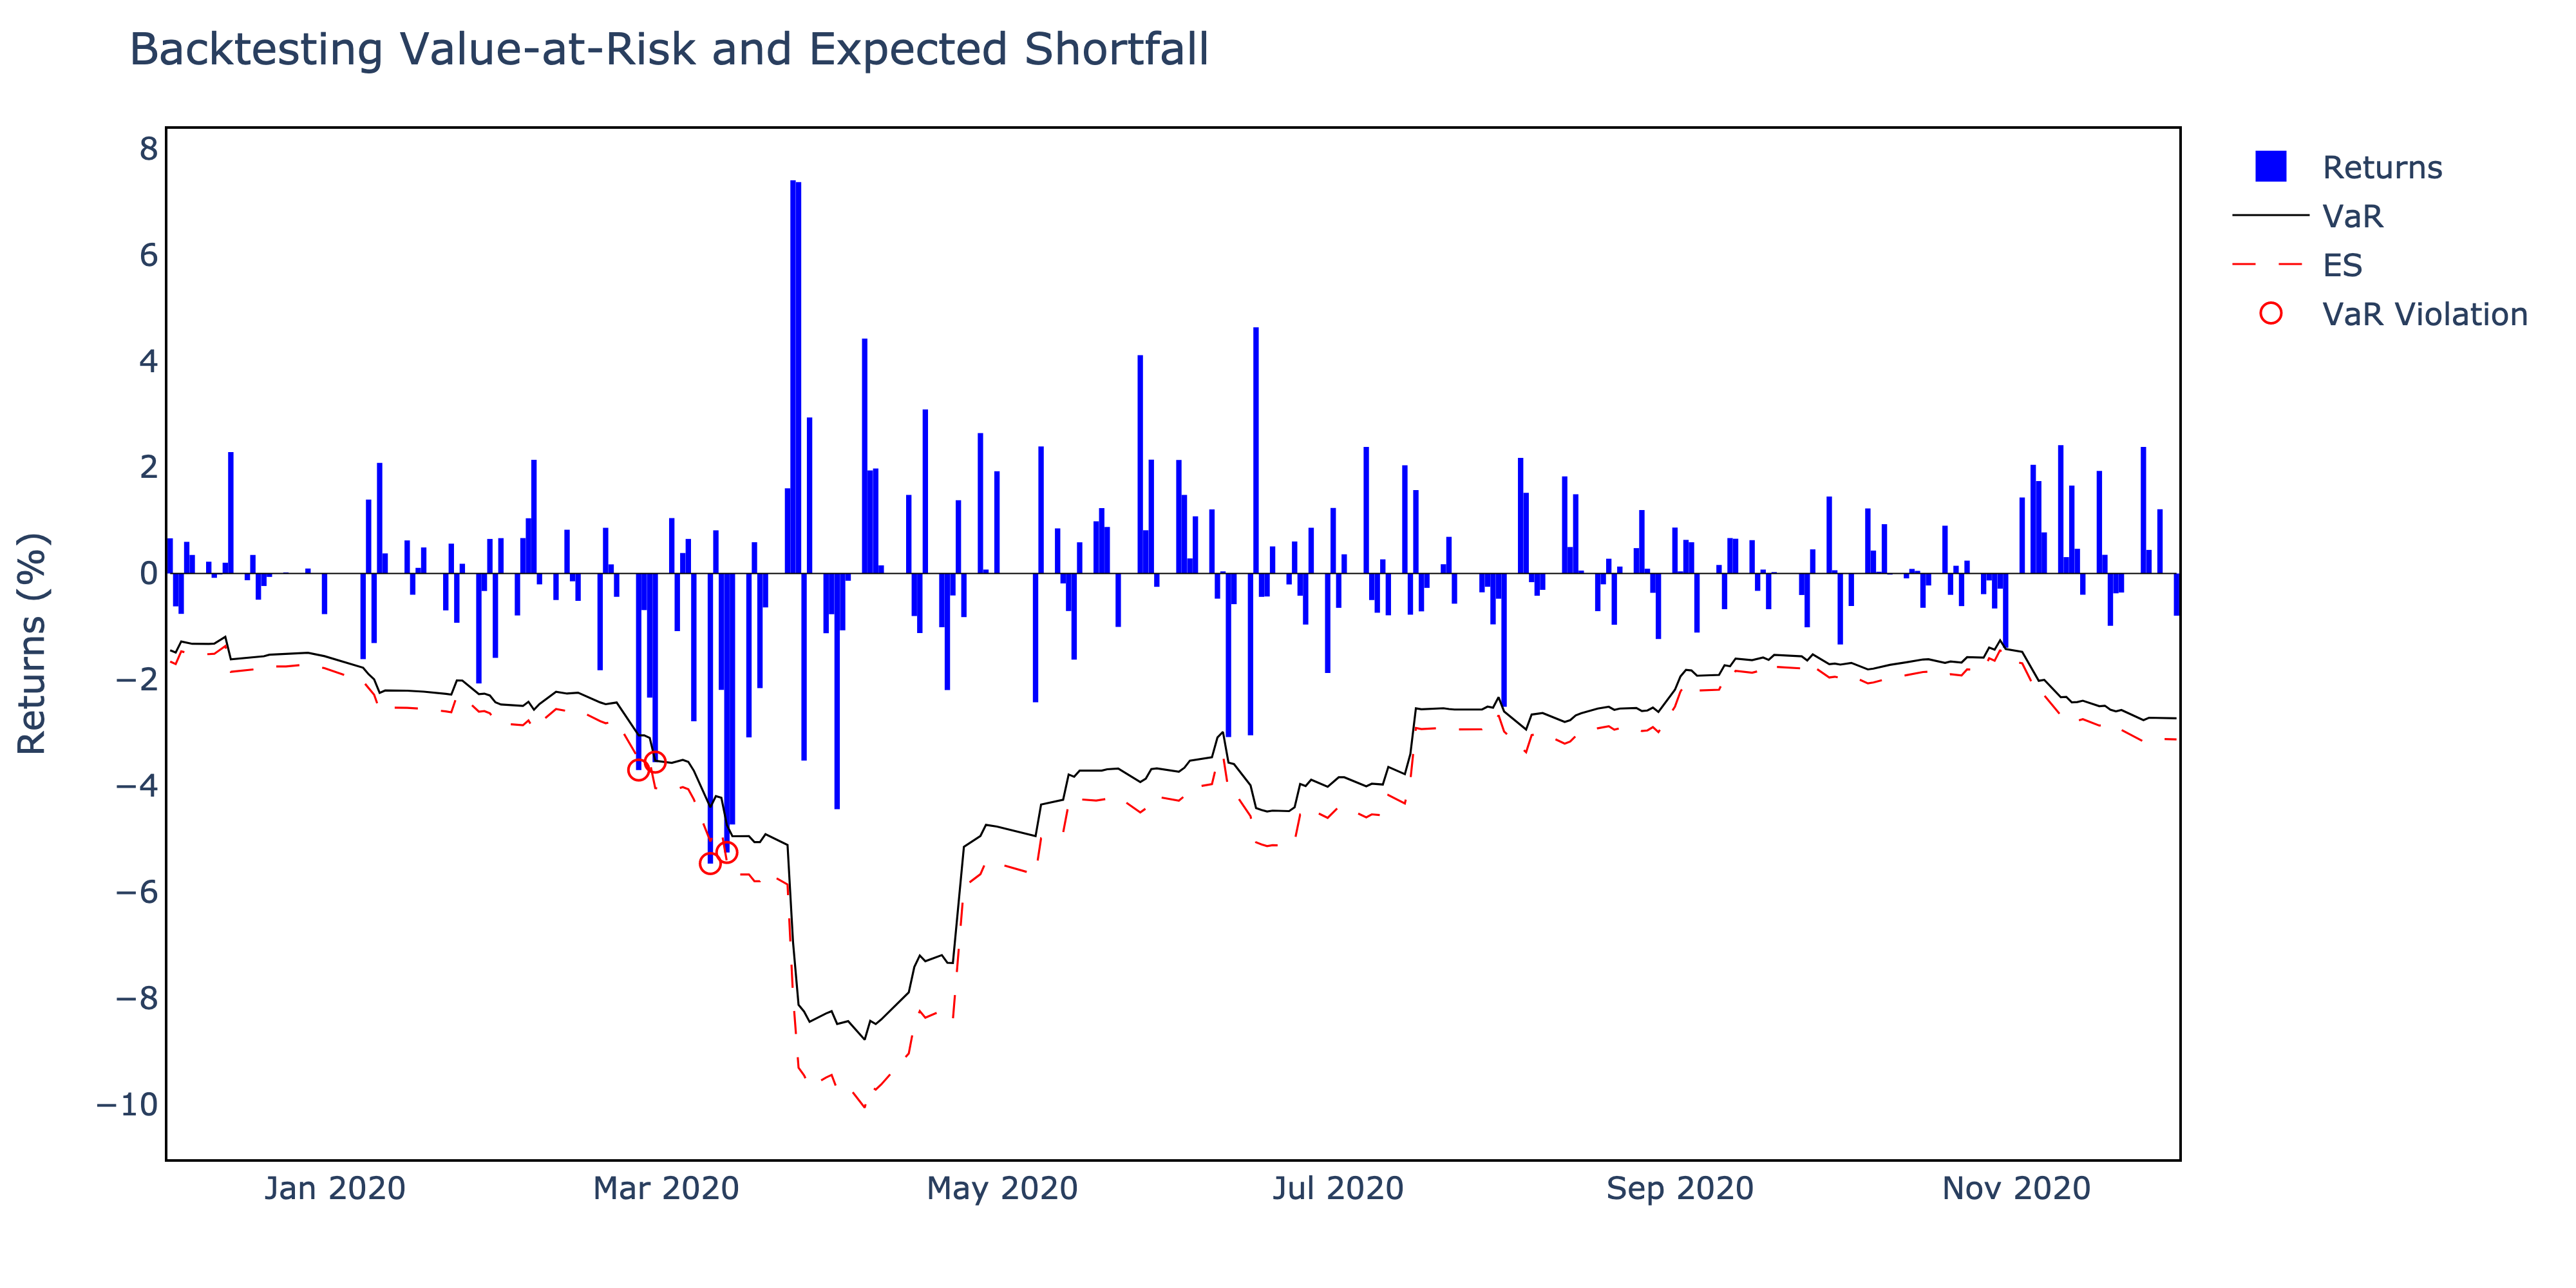


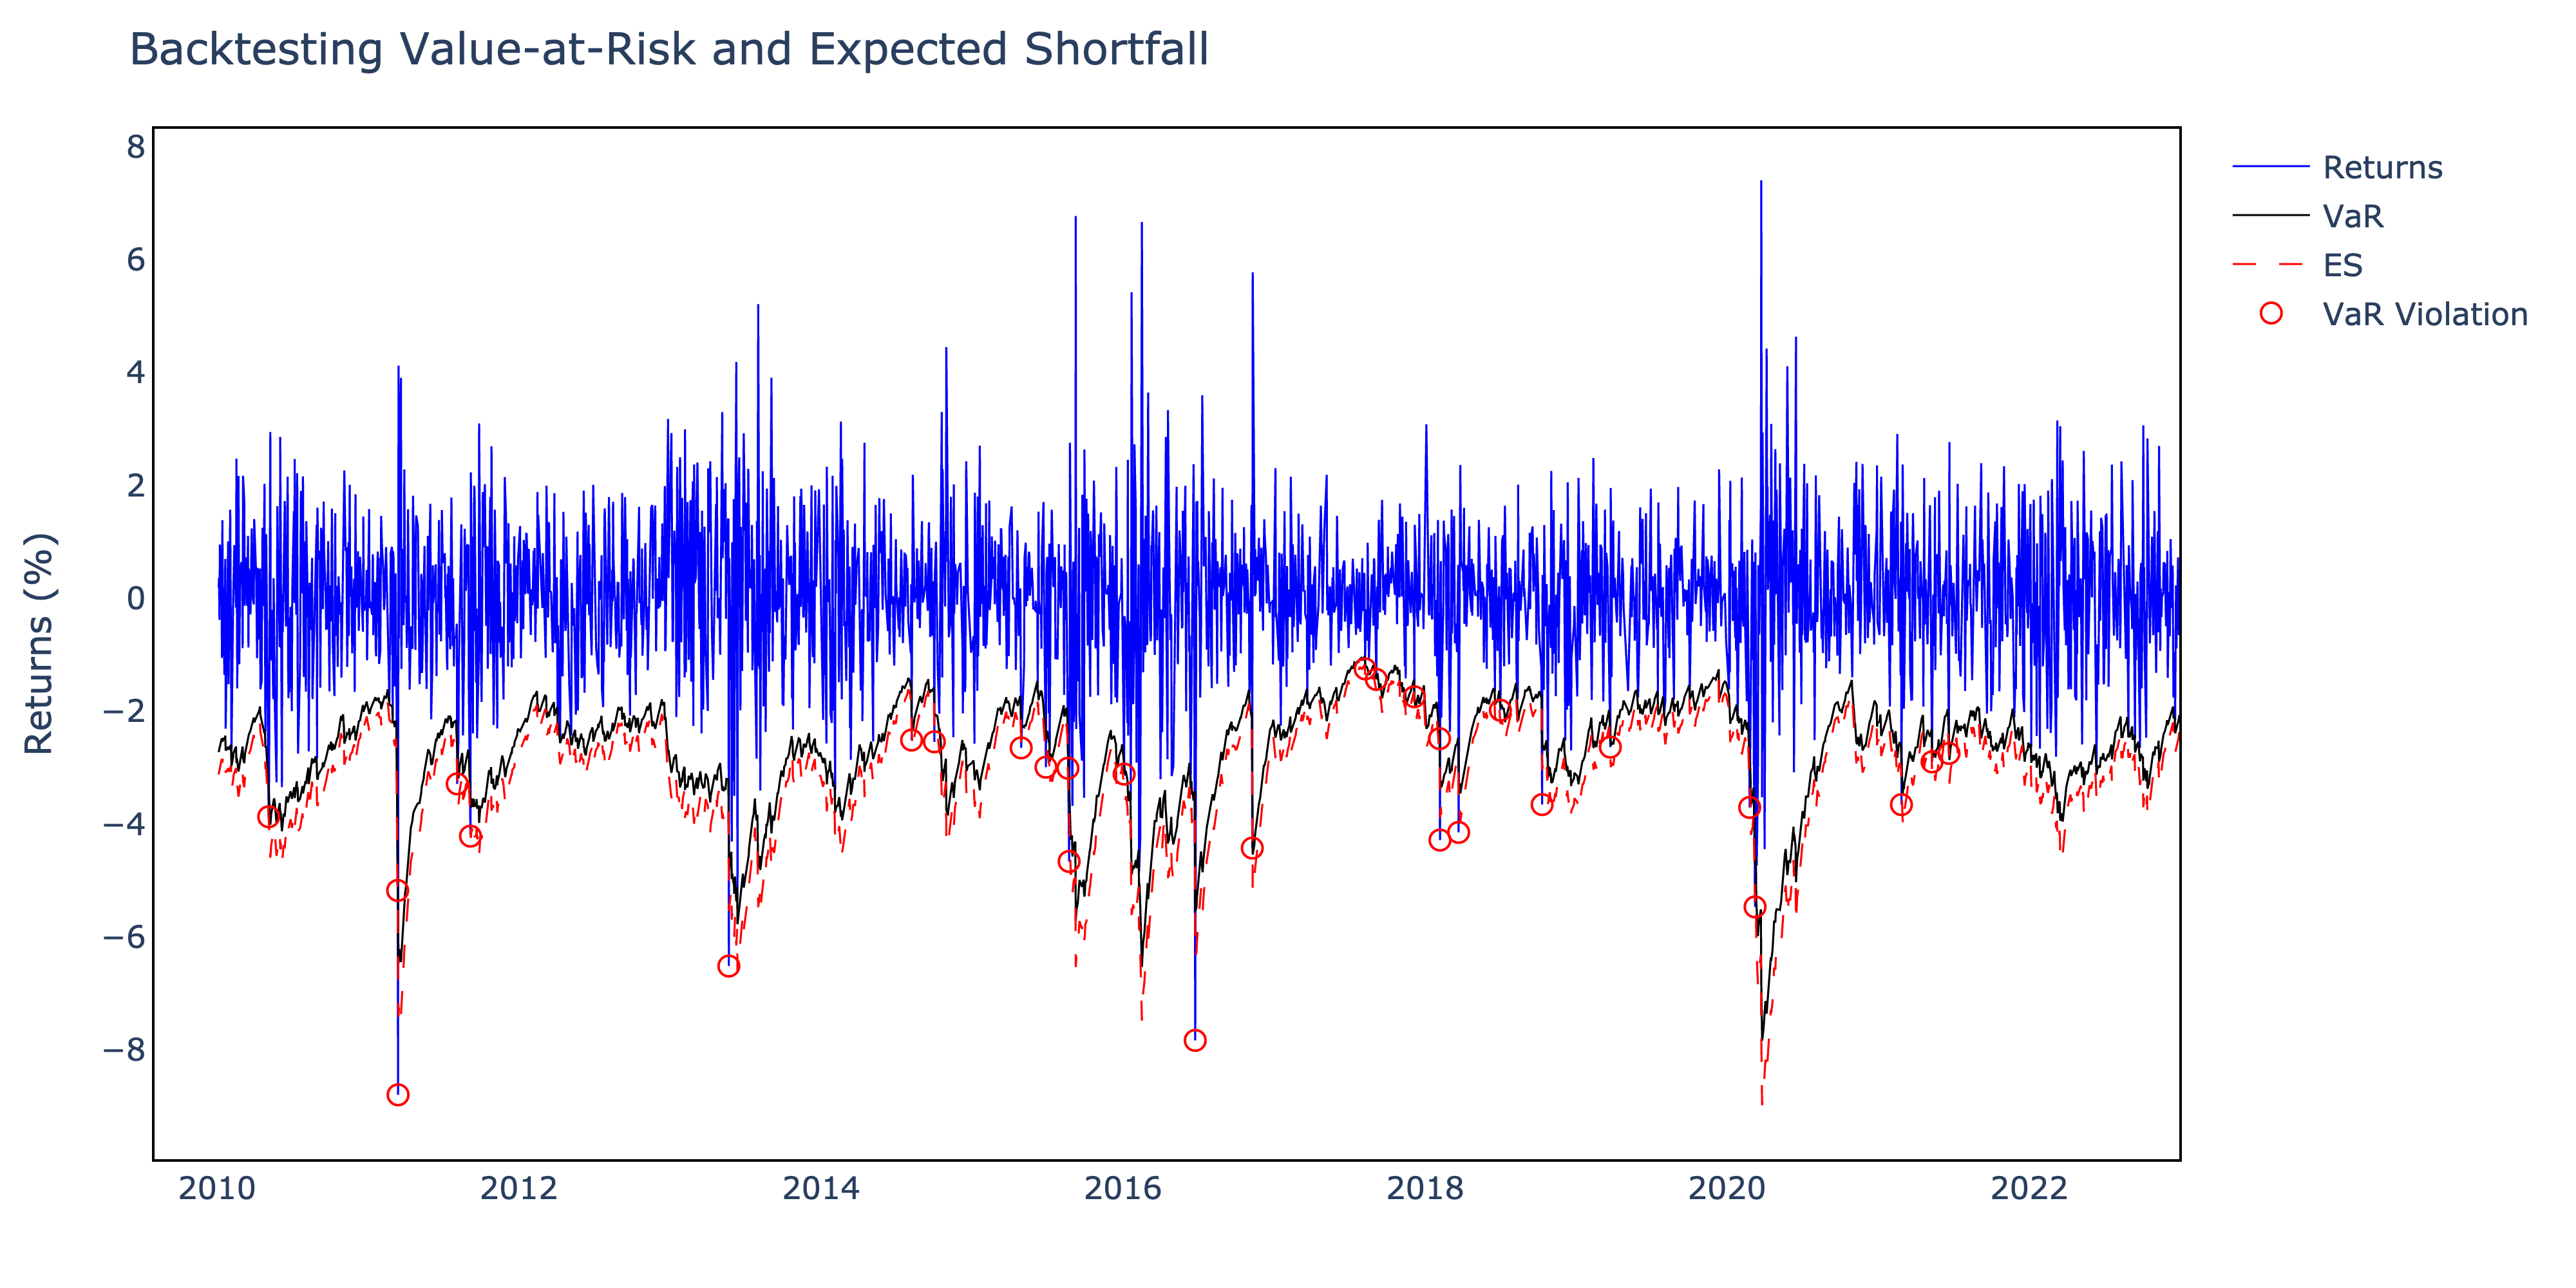

In [8]:
# Plot MA model results
fig_ma_es = IP.plot_backtest(result_ma, subset=("2019-11-30", "2020-11-30"), interactive=False)

# Plot RiskMetrics model results
fig_rm_es = IP.plot_backtest(result_rm, interactive=False)


In [9]:
violations_ma, rate_ma = BT.count_violations(result_ma)

print("== MA Correlation VaR Backtest ==")
print(f"Total Violations: {violations_ma}")
print(f"Violation Rate: {rate_ma:.2f}%")

== MA Correlation VaR Backtest ==
Total Violations: 44
Violation Rate: 1.47%


In [10]:
violations_rm, rate_rm = BT.count_violations(result_rm)

print("== RiskMetrics Correlation VaR Backtest ==")
print(f"Total Violations: {violations_rm}")
print(f"Violation Rate: {rate_rm:.2f}%")

== RiskMetrics Correlation VaR Backtest ==
Total Violations: 29
Violation Rate: 0.97%


In [11]:
fig_ma_vol = IP.plot_volatility(result_ma["Volatility"])
fig_rm_vol = IP.plot_volatility(result_rm["Volatility"])

### Bakctesting 

In [12]:
# 1. Recompute monetary positions (already done)
x_rm = deepcopy(x_matrix)

# 2. Run RiskMetrics Correlation VaR
result_rm = CM.var_corr_riskmetrics(x_rm)

# 3. Count violations
total_violations, violation_rate = BT.count_violations(result_rm)

# 4. Run Kupiec test
confidence_level = 0.99  # adjust if needed
kupiec_results = BT.kupiec_test(total_violations, len(result_rm), confidence_level)

# 5. Run Christoffersen test
christoffersen_results = BT.christoffersen_test(result_rm)

# 6. Joint test
joint_results = BT.joint_lr_test(
    LR_uc=kupiec_results["LR_uc"],
    LR_c=christoffersen_results["LR_c"]
)


In [13]:
print("=== VaR Backtesting Summary ===")
print(f"Total Violations: {total_violations}")
print(f"Violation Rate: {violation_rate:.2f}%")

print("\n-- Kupiec Test --")
for k, v in kupiec_results.items():
    print(f"{k}: {v}")

print("\n-- Christoffersen Test --")
for k, v in christoffersen_results.items():
    print(f"{k}: {v}")

print("\n-- Joint Test --")
for k, v in joint_results.items():
    print(f"{k}: {v}")


=== VaR Backtesting Summary ===
Total Violations: 29
Violation Rate: 0.97%

-- Kupiec Test --
LR_uc: 0.03749435317655525
p_value: 0.8464620144176702
reject_null: False

-- Christoffersen Test --
LR_c: 9.325060048746764
p_value: 0.002260409127891827
reject_null: True

-- Joint Test --
LR_total: 9.362554401923319
p_value: 0.009267170286543891
reject_null: True
